Human Activity Tracker

Human Activity Detection is the problem of predicting what a person is doing based on a trace of their movement using sensors. The "Human Activity Detection #Dataset" includes data collected from 34 subjects, each of whom were asked to perform 18 tasks for 3 minutes each. Each subject had a smartwatch placed on his/her dominant hand and a smartphone in their pocket. The data collection was controlled by a custom-made app that ran on the #smartphone and #smartwatch. The sensor data that was collected was from the accelerometer and gyroscope on both the smartphone and smartwatch, yielding four total sensors. The sensor data was collected at a rate of 20 Hz (i.e., every 50ms). The smartphone was either the Google Nexus 5/5X or Samsung Galaxy S5 running Android 6.0 (Marshmallow). The smartwatch was the LG G Watch running Android Wear 1.5.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('wisdm-dataset/raw/phone/accel'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



wisdm-dataset/raw/phone/accel\.DS_Store
wisdm-dataset/raw/phone/accel\data_1600_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1601_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1602_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1603_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1604_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1605_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1606_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1607_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1608_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1609_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1610_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1611_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1612_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1613_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1614_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1615_accel_phone.txt
wisdm-dataset/raw/phone/accel\data_1616_accel_phone.txt
wisdm-da

In [2]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
#import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, Conv2D, LSTM, MaxPooling2D, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import np_utils
import torch


In [3]:
np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Phone Accelerometer Train/test

In [4]:
columns=['user','activity','time','x','y','z']

data_phone_accel_sum = pd.DataFrame(data=None,columns=columns)
for dirname, _, filenames in os.walk('wisdm-dataset/raw/phone/accel'):
    for filename in filenames:
        if filename == (".DS_Store"):
            continue
        df = pd.read_csv('wisdm-dataset/raw/phone/accel/'+filename , sep=",", header=None)
        temp=pd.DataFrame(data=df.values, columns=columns)
        data_phone_accel_sum=pd.concat([data_phone_accel_sum,temp])

In [5]:
data_phone_accel_sum['z'] = data_phone_accel_sum['z'].str.replace(';','')
data_phone_accel_sum['activity'].value_counts()
data_phone_accel_sum['x']=data_phone_accel_sum['x'].astype('float')
data_phone_accel_sum['y']=data_phone_accel_sum['y'].astype('float')
data_phone_accel_sum['z']=data_phone_accel_sum['z'].astype('float')
data_phone_accel_sum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4804403 entries, 0 to 160778
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user      object 
 1   activity  object 
 2   time      object 
 3   x         float64
 4   y         float64
 5   z         float64
dtypes: float64(3), object(3)
memory usage: 256.6+ MB


Phone Gyro files import Train/test

In [6]:

data_phone_gyro_sum = pd.DataFrame(data=None,columns=columns)
for dirname, _, filenames in os.walk('wisdm-dataset/raw/phone/gyro'):
    for filename in filenames:
        if filename == (".DS_Store"):
            continue
        df = pd.read_csv('wisdm-dataset/raw/phone/gyro/'+filename , sep=",", header=None)
        temp=pd.DataFrame(data=df.values, columns=columns)
        data_phone_gyro_sum=pd.concat([data_phone_gyro_sum,temp])

In [7]:
data_phone_gyro_sum['z'] = data_phone_gyro_sum['z'].str.replace(';','')

data_phone_gyro_sum['x']=data_phone_gyro_sum['x'].astype('float')
data_phone_gyro_sum['y']=data_phone_gyro_sum['y'].astype('float')
data_phone_gyro_sum['z']=data_phone_gyro_sum['z'].astype('float')

data_phone_gyro_sum['activity'].value_counts()
data_phone_gyro_sum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3608635 entries, 0 to 80347
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user      object 
 1   activity  object 
 2   time      object 
 3   x         float64
 4   y         float64
 5   z         float64
dtypes: float64(3), object(3)
memory usage: 192.7+ MB


Watch Gyro files import train/test

In [8]:

data_watch_gyro_sum = pd.DataFrame(data=None,columns=columns)
for dirname, _, filenames in os.walk('wisdm-dataset/raw/watch/gyro'):
    for filename in filenames:
        if filename == (".DS_Store"):
            continue
        df = pd.read_csv('wisdm-dataset/raw/watch/gyro/'+filename , sep=",", header=None)
        temp=pd.DataFrame(data=df.values, columns=columns)
        data_watch_gyro_sum=pd.concat([data_watch_gyro_sum,temp])

In [9]:
data_watch_gyro_sum['z'] = data_watch_gyro_sum['z'].str.replace(';','')
data_watch_gyro_sum['x']=data_watch_gyro_sum['x'].astype('float')
data_watch_gyro_sum['y']=data_watch_gyro_sum['y'].astype('float')
data_watch_gyro_sum['z']=data_watch_gyro_sum['z'].astype('float')

data_watch_gyro_sum['activity'].value_counts()
data_watch_gyro_sum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440342 entries, 0 to 66555
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user      object 
 1   activity  object 
 2   time      object 
 3   x         float64
 4   y         float64
 5   z         float64
dtypes: float64(3), object(3)
memory usage: 183.7+ MB


Watch accelorometer files import train test

In [10]:

data_watch_accel_sum = pd.DataFrame(data=None,columns=columns)
for dirname, _, filenames in os.walk('wisdm-dataset/raw/watch/accel'):
    for filename in filenames:
        if filename == (".DS_Store"):
            continue
        df = pd.read_csv('wisdm-dataset/raw/watch/accel/'+filename , sep=",", header=None)
        temp=pd.DataFrame(data=df.values, columns=columns)
        data_watch_accel_sum=pd.concat([data_watch_accel_sum,temp])

In [11]:
data_watch_accel_sum['z'] = data_watch_accel_sum['z'].str.replace(';','')
data_watch_accel_sum['x']=data_watch_accel_sum['x'].astype('float')
data_watch_accel_sum['y']=data_watch_accel_sum['y'].astype('float')
data_watch_accel_sum['z']=data_watch_accel_sum['z'].astype('float')

data_watch_accel_sum['activity'].value_counts()
data_watch_accel_sum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3777046 entries, 0 to 66591
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user      object 
 1   activity  object 
 2   time      object 
 3   x         float64
 4   y         float64
 5   z         float64
dtypes: float64(3), object(3)
memory usage: 201.7+ MB


Combining Phone accel and gyro data

In [12]:
df_phone = pd.DataFrame(data=None, columns=columns)
df_phone['user']= data_phone_accel_sum['user'].head(3608635)
df_phone['activity']= data_phone_accel_sum['activity'].head(3608635)
df_phone['time']= data_phone_accel_sum['time'].head(3608635)
df_phone['x'] = data_phone_gyro_sum['x'].values + data_phone_accel_sum['x'].head(3608635).values
df_phone['y'] = data_phone_gyro_sum['y'].values + data_phone_accel_sum['y'].head(3608635).values
df_phone['z'] = data_phone_gyro_sum['z'].values + data_phone_accel_sum['z'].head(3608635).values

Combining watch acccel and gyro data

In [13]:
df_watch = pd.DataFrame(data=None, columns=columns)
df_watch['user']= data_watch_accel_sum['user'].head(3440342)
df_watch['activity']= data_watch_accel_sum['activity'].head(3440342)
df_watch['time']= data_watch_accel_sum['time'].head(3440342)
df_watch['x'] = data_watch_gyro_sum['x'].values + data_watch_accel_sum['x'].head(3440342).values
df_watch['y'] = data_watch_gyro_sum['x'].values + data_watch_accel_sum['y'].head(3440342).values
df_watch['z'] = data_watch_gyro_sum['x'].values + data_watch_accel_sum['z'].head(3440342).values

In [14]:
df_phone['activity'].value_counts()

A    217194
K    213640
H    207882
I    207678
M    207215
G    206994
E    206992
B    205784
D    201973
P    201173
O    200160
R    196265
L    194054
S    193668
C    193031
Q    188703
F    183740
J    182489
Name: activity, dtype: int64

In [15]:
df_watch['activity'].value_counts()

E    198506
K    197861
D    195012
P    194799
Q    194782
O    192099
I    192041
H    191460
M    191170
A    190717
G    190713
S    189727
C    189302
F    187129
R    187126
B    187115
L    185677
J    185106
Name: activity, dtype: int64

Combining Phone and Watch Data

In [16]:
df_phone_watch = pd.DataFrame(data=None, columns=columns)
df_phone_watch['user']= df_phone['user'].head(3440342)
df_phone_watch['activity']= df_phone['activity'].head(3440342)
df_phone_watch['time']= df_phone['time'].head(3440342)
df_phone_watch['x'] = df_watch['x'].values + df_phone['x'].head(3440342).values
df_phone_watch['y'] = df_watch['y'].values + df_phone['y'].head(3440342).values
df_phone_watch['z'] = df_watch['z'].values + df_phone['z'].head(3440342).values

In [17]:
df_phone_watch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3440342 entries, 0 to 59277
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user      object 
 1   activity  object 
 2   time      object 
 3   x         float64
 4   y         float64
 5   z         float64
dtypes: float64(3), object(3)
memory usage: 183.7+ MB


In [18]:
df_phone_watch['activity'].value_counts()

A    208259
K    204705
M    198279
E    198059
B    196849
G    194809
D    193039
C    193031
P    192236
O    191229
H    190017
I    189812
R    187332
L    185123
S    184736
F    183740
Q    179770
J    169317
Name: activity, dtype: int64

In [19]:
Fs = 20
activities = df_phone_watch['activity'].value_counts().index
df_phone_watch = df_phone_watch.drop('time', axis=1)
df_phone_watch['activity'].value_counts()

A    208259
K    204705
M    198279
E    198059
B    196849
G    194809
D    193039
C    193031
P    192236
O    191229
H    190017
I    189812
R    187332
L    185123
S    184736
F    183740
Q    179770
J    169317
Name: activity, dtype: int64

In [20]:
df_a = df_phone_watch[df_phone_watch['activity']=='A'].head(174604)
df_m = df_phone_watch[df_phone_watch['activity']=='M'].head(174604)
df_k = df_phone_watch[df_phone_watch['activity']=='K'].head(174604)
df_p = df_phone_watch[df_phone_watch['activity']=='P'].head(174604)
df_e = df_phone_watch[df_phone_watch['activity']=='E'].head(174604)
df_o = df_phone_watch[df_phone_watch['activity']=='O'].head(174604)
df_c = df_phone_watch[df_phone_watch['activity']=='C'].head(174604)
df_d = df_phone_watch[df_phone_watch['activity']=='D'].head(174604)
df_l = df_phone_watch[df_phone_watch['activity']=='L'].head(174604)
df_b = df_phone_watch[df_phone_watch['activity']=='B'].head(174604)
df_h = df_phone_watch[df_phone_watch['activity']=='H'].head(174604)
df_f = df_phone_watch[df_phone_watch['activity']=='F'].head(174604)
df_g = df_phone_watch[df_phone_watch['activity']=='G'].head(174604)
df_q = df_phone_watch[df_phone_watch['activity']=='Q'].head(174604)
df_r = df_phone_watch[df_phone_watch['activity']=='R'].head(174604)
df_s = df_phone_watch[df_phone_watch['activity']=='S'].head(174604)
df_i = df_phone_watch[df_phone_watch['activity']=='I'].head(174604)
df_j = df_phone_watch[df_phone_watch['activity']=='J']

In [21]:
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([df_a,df_m,df_k,df_p,df_e,df_o,df_c,df_d,df_l,df_b,df_h,df_f,df_g,df_q,df_r,df_s,df_i,df_j]) 
balanced_data['activity'].value_counts()

C:\Users\Admin\AppData\Local\Temp\ipykernel_27672\3368879018.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_data = balanced_data.append([df_a,df_m,df_k,df_p,df_e,df_o,df_c,df_d,df_l,df_b,df_h,df_f,df_g,df_q,df_r,df_s,df_i,df_j])


A    174604
M    174604
I    174604
S    174604
R    174604
Q    174604
G    174604
F    174604
H    174604
B    174604
L    174604
D    174604
C    174604
O    174604
E    174604
P    174604
K    174604
J    169317
Name: activity, dtype: int64

In [22]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['user'])
balanced_data['activity'] = label.fit_transform(balanced_data['activity']) 
balanced_data = balanced_data.drop('user', axis=1)
balanced_data


,activity,x,y,z,label
0,0,6.188597,8.814006,10.455713,0
1,0,3.605272,10.013322,8.263343,0
2,0,4.606045,11.376722,8.513901,0
3,0,2.718174,13.761097,5.978487,0
4,0,1.299151,14.153046,3.168536,0
...,...,...,...,...,...
36003,9,-13.463638,-8.818773,-2.320777,40
36004,9,-13.582652,-9.013937,-2.345182,40
36005,9,-13.629185,-8.722762,-2.201741,40
36006,9,-13.675635,-9.399319,-2.620970,40


In [23]:
label.classes_

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'O', 'P', 'Q', 'R', 'S'], dtype=object)

**Statndardize Data**

In [24]:
from sklearn.preprocessing import StandardScaler

x = balanced_data[['x','y','z']]
y = balanced_data['label']
scaler = StandardScaler()
x = scaler.fit_transform(x)

scaled_x = pd.DataFrame(data=x, columns=['x','y','z'])
scaled_x['label'] = y.values
scaled_x.insert(0, 'activity', balanced_data['activity'].values)

scaled_x

,activity,x,y,z,label
0,0,0.644592,1.511277,1.015689,0
1,0,0.362824,1.640989,0.721891,0
2,0,0.471980,1.788448,0.755468,0
3,0,0.266066,2.046331,0.415699,0
4,0,0.111291,2.088722,0.039139,0
...,...,...,...,...,...
3137580,9,-1.498913,-0.395803,-0.696481,40
3137581,9,-1.511894,-0.416911,-0.699752,40
3137582,9,-1.516970,-0.385419,-0.680529,40
3137583,9,-1.522036,-0.458592,-0.736710,40


**Frame Preparation**

In [25]:
import scipy.stats as stats
Fs=20
frame_size = Fs*4 #80
hop_size = Fs*2 #40
N_FEATURES = 4

In [26]:
def get_frames(df, frame_size, hop_size):
    
    frames = []
    labels = []
    for i in range(0,len(df )- frame_size, hop_size):
        x = df['x'].values[i: i+frame_size]
        y = df['y'].values[i: i+frame_size]
        z = df['z'].values[i: i+frame_size]
        activ = df['activity'].values[i: i+frame_size]
        
        label = stats.mode(df['label'][i: i+frame_size])[0][0]
        frames.append([activ,x,y,z])
        labels.append(label)
        
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)
    
    return frames, labels

x,y = get_frames(scaled_x, frame_size, hop_size)

C:\Users\Admin\AppData\Local\Temp\ipykernel_27672\3232465496.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label'][i: i+frame_size])[0][0]


In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.30, random_state = 0, stratify = y)

x_train = x_train.reshape(x_train.shape[0], frame_size, 4, 1)
x_test = x_test.reshape(x_test.shape[0], frame_size, 4, 1)

In [28]:
x_train.shape

(54906, 80, 4, 1)

**CNN_LSTM Model**

In [29]:
callbacks_list = [keras.callbacks.ModelCheckpoint(
        filepath='best_model/best_CNN_LSTM_model.h5',
        monitor='val_accuracy', save_best_only=True), keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
]

def make_cnn_lstm_model(lstm_neurons,dense_neurons,drop_out):
    model = Sequential()

    model.add(TimeDistributed(Conv1D(filters=256, kernel_size=2, activation='relu'), 
                            input_shape=(1, x_train.shape[1], x_train.shape[2])))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(TimeDistributed(Conv1D(filters=512, kernel_size=2, activation='relu')))
    model.add(TimeDistributed(Dropout(drop_out)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    # LSTM layer
    model.add(LSTM(lstm_neurons))
    model.add(Dropout(drop_out)) 
    #Final layers
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dense(41, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# reshape data into time steps of sub-sequences
model = make_cnn_lstm_model(lstm_neurons= 256, dense_neurons = 100, drop_out = 0.5)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 79, 256)       2304      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 79, 256)       0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 78, 512)       262656    
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 78, 512)       0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 39, 512)       0

In [30]:
from sklearn.preprocessing import LabelBinarizer

label_as_binary = LabelBinarizer()
y_train_labels = label_as_binary.fit_transform(y_train)
x_train_1 = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])


In [33]:
history = model.fit(x_train_1, y_train_labels, validation_split=0.2, batch_size=80, epochs=100, callbacks=callbacks_list)

Epoch 1/100
550/550 [==============================] - 57s 104ms/step - loss: 1.4354 - accuracy: 0.5479 - val_loss: 1.1737 - val_accuracy: 0.6394
Epoch 2/100
550/550 [==============================] - 58s 105ms/step - loss: 1.4062 - accuracy: 0.5581 - val_loss: 1.1085 - val_accuracy: 0.6559
Epoch 3/100
550/550 [==============================] - 58s 105ms/step - loss: 1.3539 - accuracy: 0.5764 - val_loss: 1.0597 - val_accuracy: 0.6817
Epoch 4/100
550/550 [==============================] - 58s 105ms/step - loss: 1.3112 - accuracy: 0.5866 - val_loss: 1.0212 - val_accuracy: 0.6922
Epoch 5/100
550/550 [==============================] - 57s 104ms/step - loss: 1.2634 - accuracy: 0.6015 - val_loss: 1.1108 - val_accuracy: 0.6522
Epoch 6/100
550/550 [==============================] - 57s 104ms/step - loss: 1.2332 - accuracy: 0.6109 - val_loss: 0.9374 - val_accuracy: 0.7198
Epoch 7/100
550/550 [==============================] - 56s 103ms/step - loss: 1.2026 - accuracy: 0.6223 - val_loss: 0.9448 -

Epoch 57/100
550/550 [==============================] - 56s 103ms/step - loss: 0.6819 - accuracy: 0.7796 - val_loss: 0.6850 - val_accuracy: 0.7963
Epoch 58/100
550/550 [==============================] - 57s 103ms/step - loss: 0.6682 - accuracy: 0.7862 - val_loss: 0.6767 - val_accuracy: 0.8025
Epoch 59/100
550/550 [==============================] - 57s 103ms/step - loss: 0.6752 - accuracy: 0.7805 - val_loss: 0.5980 - val_accuracy: 0.8228
Epoch 60/100
550/550 [==============================] - 57s 103ms/step - loss: 0.6608 - accuracy: 0.7870 - val_loss: 0.6635 - val_accuracy: 0.8062
Epoch 61/100
550/550 [==============================] - 57s 103ms/step - loss: 0.6766 - accuracy: 0.7818 - val_loss: 0.6051 - val_accuracy: 0.8257
Epoch 62/100
550/550 [==============================] - 57s 103ms/step - loss: 0.6661 - accuracy: 0.7857 - val_loss: 0.6702 - val_accuracy: 0.8081
Epoch 63/100
550/550 [==============================] - 56s 103ms/step - loss: 0.6615 - accuracy: 0.7871 - val_loss: 0

In [34]:
import tikzplotlib

def plot_accuracy(model):
    plt.figure(figsize=(10, 5))
    plt.plot(model.history['accuracy'], 'g--', label='Accuracy of training data') 
    plt.plot(model.history['val_accuracy'], 'g', label='Accuracy of validation data')
    plt.legend(loc='center left', shadow=True, fontsize=17)
    plt.ylabel('Training Progress', fontsize=17)
    plt.xlabel('Training Epoch', fontsize=17)
    plt.ylim(0)
    plt.legend()
    plt.show()

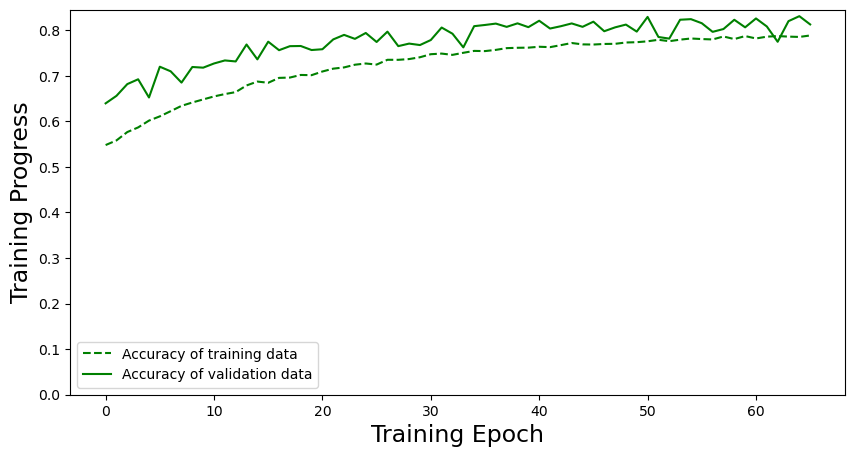

In [35]:
plot_accuracy(history)

In [36]:
def plot_loss(model):
    plt.figure(figsize=(10, 5))
    plt.plot(model.history['loss'], 'r--', label='Loss of training data')
    plt.plot(model.history['val_loss'], 'r', label='Loss of validation data')
    plt.legend(loc='center left', shadow=True, fontsize=17)
    plt.ylabel('Training Progress', fontsize=17)
    plt.xlabel('Training Epoch', fontsize=17)
    plt.ylim(0)
    plt.legend()


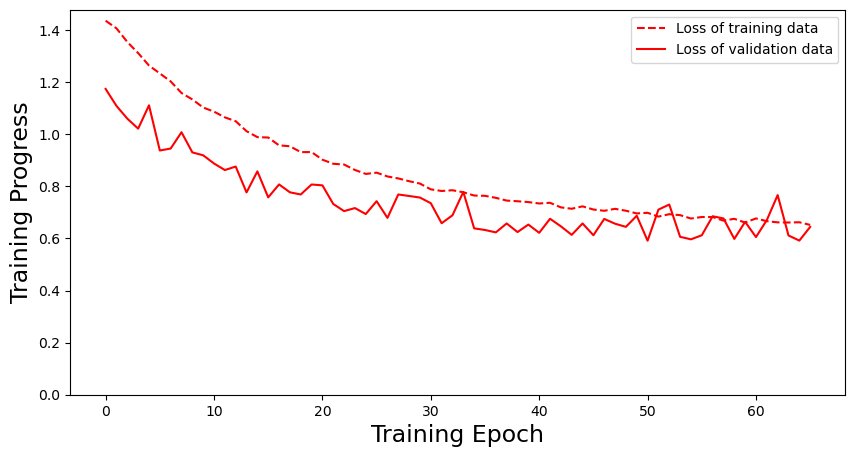

In [37]:
plot_loss(history)

In [38]:
def plot(model):
    plt.figure(figsize=(10, 7))
    plt.plot(model.history['accuracy'], 'g--', label='Accuracy of training data')
    plt.plot(model.history['val_accuracy'], 'g', label='Accuracy of validation data')
    plt.plot(model.history['loss'], 'r--', label='Loss of training data')
    plt.plot(model.history['val_loss'], 'r', label='Loss of validation data')
    plt.legend(loc='upper right', shadow=True, fontsize=17)
    plt.ylabel('Training Progress', fontsize=17)
    plt.xlabel('Training Epoch', fontsize=17)
    plt.ylim(0)
    plt.legend()

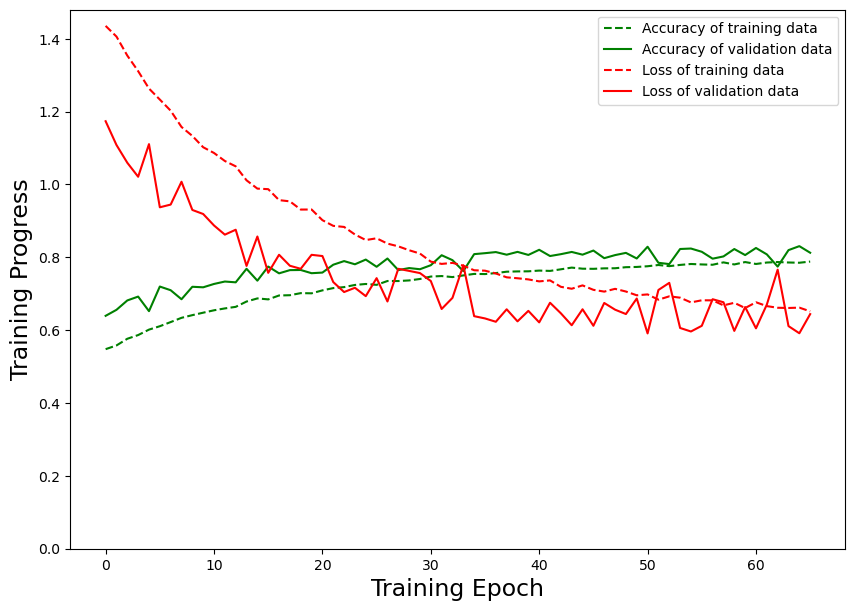

In [39]:
plot(history)

In [40]:
from keras.models import load_model
best_model = load_model('best_model/best_CNN_LSTM_model.h5')

In [41]:
# reshape data into time steps of sub-sequences
y_test_labels = label_as_binary.fit_transform(y_test)
x_test_1 = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])

score = best_model.evaluate(x_test_1, y_test_labels, verbose=1, batch_size=60)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

393/393 [==============================] - 5s 12ms/step - loss: 0.5925 - accuracy: 0.8281

Accuracy on test data: 0.83

Loss on test data: 0.59


393/393 [==============================] - 5s 12ms/step


<AxesSubplot:title={'center':'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

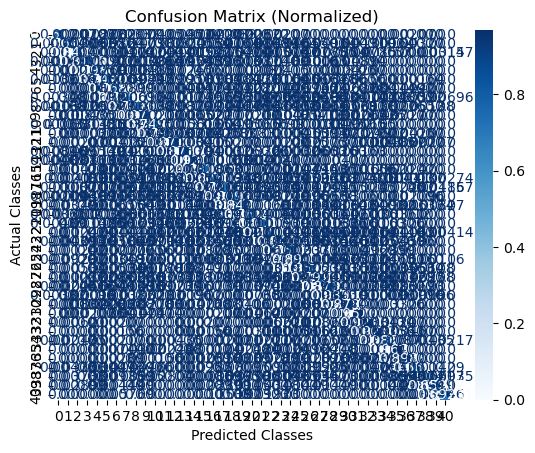

In [42]:
# Take the class with the highest probability from the test predictions
y_pred_test = best_model.predict(x_test_1, batch_size=60)
max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_labels, axis = 1)
#Confusion Matrix
from pycm import *
cm = ConfusionMatrix(actual_vector= max_y_test, predict_vector= max_y_pred_test)
cm.plot(cmap=plt.cm.Blues,normalized=True,number_label=True,plot_lib="seaborn")


In [43]:
def confusion_matrix(y, y_pred):
    matrix =metrics.confusion_matrix(y, y_pred)
    group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     matrix.flatten()/np.sum(matrix)]
    labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(41,41)
    plt.figure(figsize=(11, 8))
    ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='coolwarm', linecolor='white', linewidths=1)
    ax.set_xlabel('Predicted Activity', fontsize=15)
    ax.set_ylabel('True Activity', fontsize=15)


393/393 [==============================] - 5s 12ms/step
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       482
           1       0.89      0.76      0.82       611
           2       0.81      0.85      0.83       637
           3       0.82      0.81      0.81       614
           4       0.76      0.80      0.78       482
           5       0.82      0.74      0.78       610
           6       0.88      0.77      0.82       483
           7       0.83      0.73      0.77       575
           8       0.73      0.78      0.76       724
           9       0.77      0.87      0.82       460
          10       0.82      0.75      0.78       606
          11       0.92      0.79      0.85       482
          12       0.92      0.87      0.89       482
          13       0.81      0.88      0.84       613
          14       0.78      0.92      0.84      1228
          15       0.80      0.78      0.79       483
          16       0.77  

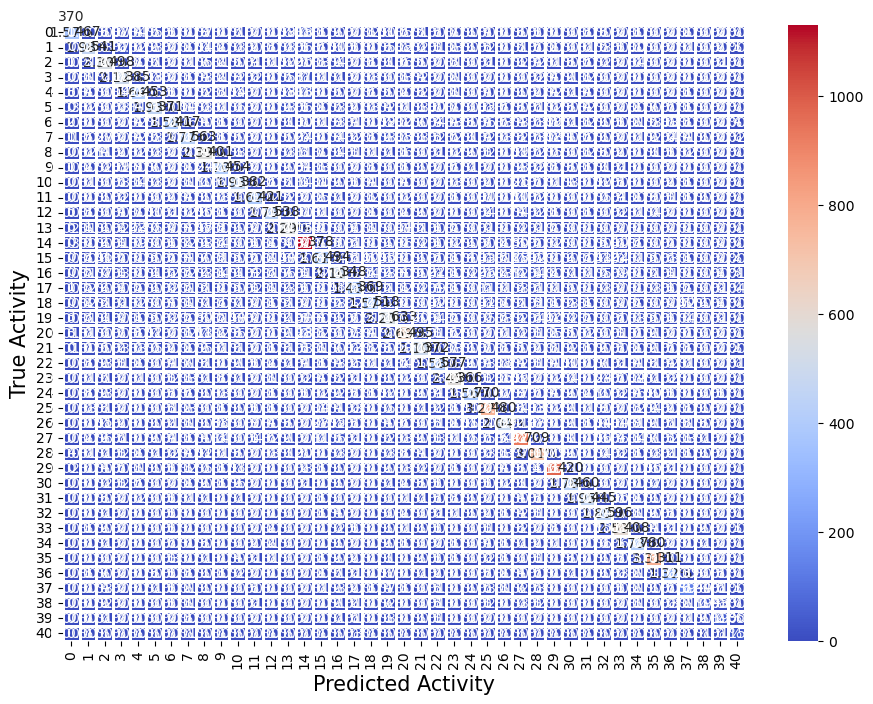

In [44]:
# Take the class with the highest probability from the test predictions
y_pred_test = best_model.predict(x_test_1, batch_size=60)
max_y_pred_test = np.argmax(y_pred_test, axis = 1)
max_y_test = np.argmax(y_test_labels, axis = 1)

print(metrics.classification_report(max_y_test, max_y_pred_test))
confusion_matrix(max_y_test, max_y_pred_test)